# **Dependancy**

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.layers 

from google.colab import files
import io

import tensorboard
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
pip install deepxde

# **Prepare Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Jumps to the desired directory
%cd 'drive/My Drive/Analytical Data'
p1 = genfromtxt('T_q100_v200_T25_D100.csv', delimiter=',')
times = genfromtxt('time.csv', delimiter=',')
times = times.reshape((100,1))
times.shape
times[0:5]
points = p1[:, 1:3]
points.shape
temps = p1[:, 5:]
temps.shape
train_number = 1681
num_p = 1681
# test_number = 10 * 100

/content/drive/My Drive/Analytical Data


In [5]:
temps.shape

(1681, 100)

In [6]:
times.shape

(100, 1)

Re-arranging

In [7]:
all_ = []

for j in range(100):
  new_points = np.zeros((1681, 3))
  for i in range(1681):
      new_points[i] = [points[i][0], points[i][1], times[j] * 1000] # y, z, t 
  all_.append(new_points)

new_temps = temps[:,:]
new_temps.shape

(1681, 100)

In [ ]:
all_[2].shape#0,1,2

(1681, 3)

**Randomized**

In [ ]:
 idx = np.random.randint(168100, size=1000)
 new_points=new_points[idx,:]
 new_temps = new_temps[idx,:]

**Non-randomized**

In [8]:
new_points=new_points[0:num_p,:]
new_temps = new_temps[0:num_p,:]

### Now we have an input of size 168100 by 3 and output of size 168100 by 1

In [9]:
train_x = new_points[0:train_number]
train_y = new_temps[0:train_number]
test_x = new_points[train_number:]
test_y = new_temps[train_number:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1681, 3)
(1681, 100)
(0, 3)
(0, 100)


In [10]:
map_dict =  {}
for i in range(len(train_x)):
  map_dict[(train_x[i][0], train_x[i][1], train_x[i][2])] = train_y[i]

In [ ]:
train_x[0:10] # y, z, time

array([[ 1.    ,  1.    ,  1.0971],
       [ 2.    ,  1.    ,  1.0971],
       [ 3.    ,  1.    ,  1.0971],
       [ 4.    ,  1.    ,  1.0971],
       [ 5.    ,  1.    ,  1.0971],
       [ 6.    ,  1.    ,  1.0971],
       [ 7.    ,  1.    ,  1.0971],
       [ 8.    ,  1.    ,  1.0971],
       [ 9.    ,  1.    ,  1.0971],
       [10.    ,  1.    ,  1.0971]])

In [ ]:
train_y[0:10]

array([[133.85 ],
       [133.19 ],
       [131.25 ],
       [128.13 ],
       [123.99 ],
       [119.03 ],
       [113.46 ],
       [107.51 ],
       [101.36 ],
       [ 95.204]])

# **Model and PINN**

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import deepxde as dde
from deepxde.backend import tf
models = []

for time_step in range(100):
  train_x = all_[time_step][0:train_number]
  train_y = new_temps[0:train_number, time_step].reshape((1681,1))
  map_dict =  {}
  for i in range(len(train_x)):
    map_dict[(train_x[i][0], train_x[i][1], train_x[i][2])] = train_y[i]

  
  def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_x1, dy_x2, dy_t = dy_x[:, 0:1], dy_x[:, 1:2], dy_x[:, 2:]
    dy_x1x1 = tf.gradients(dy_x1, x)[0][:, 0:1]
    dy_x2x2 = tf.gradients(dy_x2, x)[0][:, 1:2]
    return (
    dy_t - (dy_x1x1 - dy_x2x2)
    )



  def func(x):
    return np.full((len(x), 1), 10e-2)

  def funcic(x): return np.full((len(x), 1), 25)

  def funcbc(x):  # x = the collection of the points on the boundary 
    result = np.zeros((len(x), 1))
    for i in range(len(x)):
      result[i] = map_dict[(x[i][0], x[i][1], x[i][2])]  # 0: y, 1: z, 2 : time
    return result

  def solution(x) : return train_y

  geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
  timedomain = dde.geometry.TimeDomain(0, 1)
  geomtime = dde.geometry.GeometryXTime(geom, timedomain)

  bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
  # bc = PointSetBC(train_x, train_y)
  # bc = dde.boundary_conditions.OperatorBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
  ic = dde.IC(geomtime, funcic, lambda _, on_initial: on_initial)

  data = dde.data.TimePDE(
      geomtime,
      pde,
      [bc, ic],
      anchors = train_x,
      solution = solution
  )


  layer_size = [3] + [32] * 3 + [1]
  activation = "tanh"
  initializer = "Glorot uniform"
  net = dde.maps.FNN(layer_size, activation, initializer)


  model = dde.Model(data, net)

  callback = dde.callbacks.EarlyStopping(min_delta=0.001, patience=10000)

  model.compile("adam", lr=0.001,metrics=["l2 relative error"])

  losshistory, train_state = model.train(epochs=30000, callbacks = [callback])

  print(time_step)
  models.append(model)

  #dde.saveplot(losshistory, train_state, issave=False, isplot=True)

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.067620 s



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 6.079977 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.95e-03, 2.71e+03, nan]         [3.95e-03, 0.00e+00, 0.00e+00]    [9.99e-01]    
1000      [5.37e-08, 9.55e+02, nan]         [5.37e-08, 0.00e+00, 0.00e+00]    [4.70e-01]    
2000      [9.42e-09, 8.67e+02, nan]         [9.42e-09, 0.00e+00, 0.00e+00]    [4.66e-01]    
3000      [3.09e-09, 8.66e+02, nan]         [3.09e-09, 0.00e+00, 0.00e+00]    [4.70e-01]    
4000      [1.12e-09, 8.66e+02, nan]         [1.12e-09, 0.00e+00, 0.00e+00]    [4.71e-01]    
5000      [4.45e-10, 8.66e+02, nan]         [4.45e-10, 0.00e+00, 0.00e+00]    [4.71e-01]    
6000      [2.54e-10, 8.66e+02, nan]         [2.54e-10, 0.00e+00, 0.00e+00]    [4.71e-01]    
7000      [5.20e-02, 2.32e+02, nan]         [5.20e-02, 0.00e+00, 0.00e+00]    [2.70e-01]    
8000      [2.04e-02, 4.76e+01, nan]         [2.04e-02, 0.00e+00, 0.00e+00]    [2.38e-01]   

**Finding Boundary**

In [ ]:
import deepxde as dde
def func(x):
  return np.full((len(x), 1), 10e-2)
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
#geom = dde.geometry.geometry_2d.Polygon([(0, 0), (0, 40), (41, 41), (41, 0)])
timedomain = dde.geometry.TimeDomain(0, 0.01) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
# bc = PointSetBC(train_x, train_y)
bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
# bc = dde.boundary_conditions.PointSet(train_x)

In [ ]:
boundary = bc.collocation_points(train_x)
temps_on_boundary = np.zeros((len(boundary), 1))
for i in range(len(boundary)):
  temps_on_boundary[i] = map_dict[(boundary[i][0], boundary[i][1], boundary[i][2])] 
all_boundary = np.concatenate((boundary, temps_on_boundary), axis = 1)

**Plotting Boundary**

In [ ]:
all_boundary.shape

(103, 4)

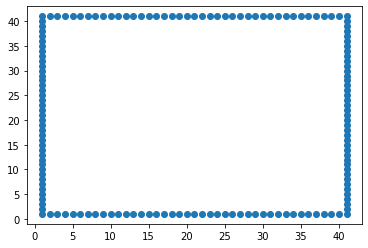

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(all_boundary[:,0], all_boundary[:,1]) 

In [ ]:
preds = []
for i in range(4):
  preds.append(models[i].predict(all_[i][0:train_number]))

Predicting...
'predict' took 0.003094 s

Predicting...
'predict' took 0.001499 s

Predicting...
'predict' took 0.001878 s

Predicting...
'predict' took 0.002430 s



In [ ]:
for i in range(0,100,10):
  print(preds[0][i], preds[1][i], preds[2][i], preds[3][i])

for i in range (0,100,10):
  print(new_temps[i][0], new_temps[i][1], new_temps[i][2], new_temps[i][3])

[131.15099] [155.87271] [184.12894] [211.76712]
[89.55112] [103.03893] [120.36405] [140.55019]
[47.40793] [50.595066] [55.093075] [59.437386]
[32.00198] [32.76735] [34.17421] [34.982567]
[27.25179] [27.220947] [27.79419] [27.86342]
[90.84437] [101.65908] [117.69956] [136.63876]
[46.59127] [51.73194] [55.529324] [58.994865]
[31.909922] [33.52157] [34.668415] [35.26596]
[27.395452] [27.647766] [28.29252] [28.215076]
[92.2075] [100.12134] [115.07281] [132.86615]
133.85 162.48 199.26 246.52
89.171 103.05 119.98 140.61
46.981 50.574 54.697 59.412
31.797 32.732 33.778 34.946
27.091 27.35 27.636 27.952
94.289 109.5 128.09 150.76
49.558 53.659 58.382 63.802
32.632 33.695 34.888 36.221
27.348 27.641 27.965 28.323
98.036 114.14 133.79 157.71


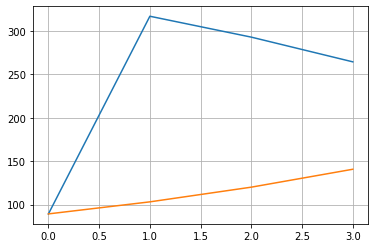

In [ ]:
times = [i for i in range(4)]
predictions = []
actuals = []
point_number = 10
for i in range(4):
  predictions.append(preds[i][point_number])
  actuals.append(new_temps[point_number][i])

fig, ax = plt.subplots()
ax.plot(times, predictions)
ax.plot(times, actuals)
plt.grid()